In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
import awkward as ak
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()
import torch

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

In [2]:
df = ak.from_parquet("all_jets_v3.parquet")

In [3]:
jets = df.jets
partons = df.partons_matched

In [4]:
jets.prov

<Array [[2, 3, -1, 4, 5], ..., [1, 5, ..., -1]] type='584143 * var * float64'>

In [5]:
matched = jets.prov != -1

In [6]:
jets_pt = ak.to_numpy(ak.flatten(jets.pt[matched]), allow_missing=False)
parton_pt = ak.to_numpy(ak.flatten(partons.pt[matched]), allow_missing=False)
parton_eta = ak.to_numpy(ak.flatten(partons.eta[matched]), allow_missing=False)

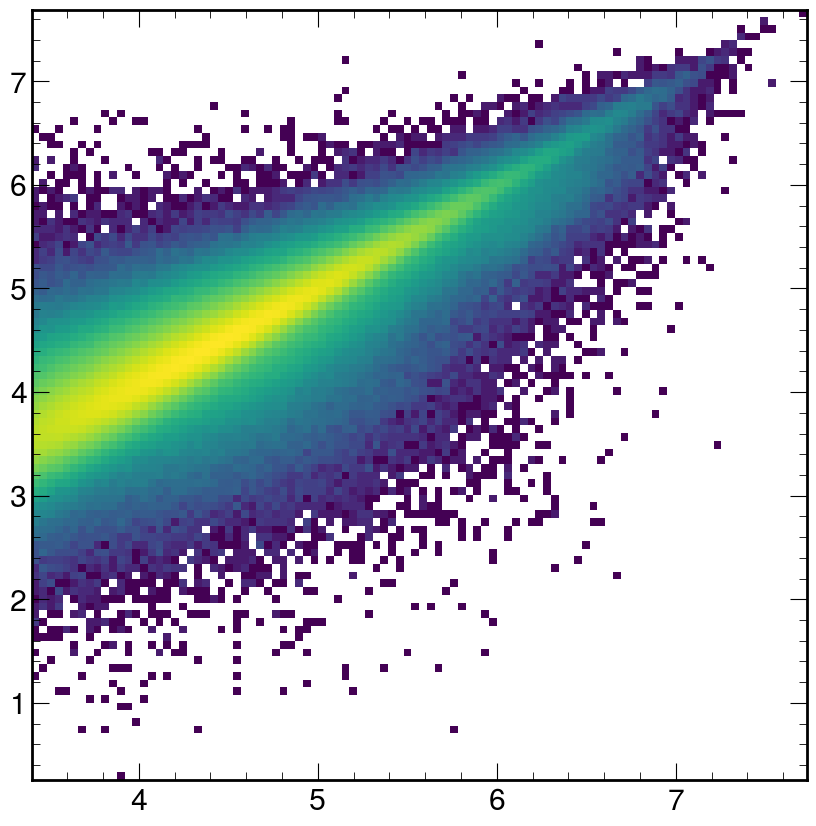

In [7]:
plt.hist2d(np.log(jets_pt), 
           np.log(parton_pt),
           bins=100, norm=LogNorm());

In [8]:
import zuko
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform, DiagNormal

In [15]:
flow = zuko.flows.MAF(1, context=1, transforms=2, hidden_features=[32,32], 
                      randperm=True,
                      base=DiagNormal)

In [16]:
flow

MAF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=2, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=2, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: tensor([0.]), scale: tensor([1.]))
)

In [43]:
flow.base(torch.Tensor([1, 2,3]))

DiagNormal(loc: tensor([0.]), scale: tensor([1.]))

In [47]:
flow.base(torch.Tensor([1, 2,3])).batch_shape

torch.Size([])

In [49]:
base_distr = flow.base

In [54]:
y = torch.Tensor([[0.,1.,2.,3.],[0.,1.,2.,3]])
y.shape

torch.Size([2, 4])

In [60]:
base_concrete = base_distr(y)
base_concrete

DiagNormal(loc: tensor([0.]), scale: tensor([1.]))

In [68]:
print(f"{base_concrete.event_shape=}   {base_concrete.batch_shape=}")

base_concrete.event_shape=torch.Size([1])   base_concrete.batch_shape=torch.Size([])


In [72]:
base_expanded = base_concrete.expand(y.shape[:-1])
base_expandedpor

DiagNormal(loc: torch.Size([2, 1]), scale: torch.Size([2, 1]))

In [73]:
print(f"{base_expanded.event_shape=}   {base_expanded.batch_shape=}")

base_expanded.event_shape=torch.Size([1])   base_expanded.batch_shape=torch.Size([2])


In [76]:
base_concrete.reinterpreted_batch_ndims

1

In [75]:
base_expanded.reinterpreted_batch_ndims

1

In [ ]:
cond 

In [38]:
help(flow.base())

Help on DiagNormal in module zuko.distributions object:

class DiagNormal(torch.distributions.independent.Independent)
 |  DiagNormal(loc: torch.Tensor, scale: torch.Tensor, ndims: int = 1)
 |  
 |  Creates a multivariate normal distribution parametrized by the variables
 |  mean :math:`\mu` and standard deviation :math:`\sigma`, but assumes no
 |  correlation between the variables.
 |  
 |  Arguments:
 |      loc: The mean :math:`\mu` of the variables.
 |      scale: The standard deviation :math:`\sigma` of the variables.
 |      ndims: The number of batch dimensions to interpret as event dimensions.
 |  
 |  Example:
 |      >>> d = DiagNormal(torch.zeros(3), torch.ones(3))
 |      >>> d.event_shape
 |      torch.Size([3])
 |      >>> d.sample()
 |      tensor([ 0.7304, -0.1976, -1.7591])
 |  
 |  Method resolution order:
 |      DiagNormal
 |      torch.distributions.independent.Independent
 |      torch.distributions.distribution.Distribution
 |      builtins.object
 |  
 |  Method

In [60]:
parton_pt

array([ 78.609375  ,  73.28515625,  30.55859375, ..., 136.25      ,
       128.984375  ,  58.27539062])

In [67]:
parton_pt.shape

(2852691,)

In [11]:
base = flow(torch.Tensor([100])).log_prob(torch.Tensor(jets_pt))

In [12]:
base

tensor(-2.2347e+10)

In [14]:
flow(torch.Tensor([100,100])).log_prob(torch.Tensor(jets_pt))

tensor(-2.2347e+10)

In [23]:
parton_pt[:, None]

array([[ 78.609375  ],
       [ 73.28515625],
       [ 30.55859375],
       ...,
       [136.25      ],
       [128.984375  ],
       [ 58.27539062]])

In [27]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions.independent import Independent
loc = torch.zeros(3)
scale = torch.ones(3)
mvn = MultivariateNormal(loc, scale_tril=torch.diag(scale))


In [28]:
mvn

MultivariateNormal(loc: torch.Size([3]), scale_tril: torch.Size([3, 3]))

In [29]:
normal = Normal(loc, scale)
diagn = Independent(normal, 1)

In [30]:
diagn

Independent(Normal(loc: torch.Size([3]), scale: torch.Size([3])), 1)